## Script to plot variables from wrfouts using cartopy

Loading basic modules

In [2]:
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import numpy as np
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature
from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords,interplevel)



Loading sample file

In [3]:
ncfile = Dataset("./Zorbas_sample/wrfout_d01_2018-09-27_12:00:00")

Loading variables using wrf-python (https://wrf-python.readthedocs.io/en/latest/#)
Smoothing variable (slp)
Loading geographical info (coordinates, projection...)

In [4]:
# Get the sea level pressure
slp = getvar(ncfile, "slp")

# Smooth the sea level pressure since it tends to be noisy near the
# mountains
smooth_slp = smooth2d(slp, 3, cenweight=4)

# Get the latitude and longitude points
lats, lons = latlon_coords(slp)

# Get the cartopy mapping object
cart_proj = get_cartopy(slp)

### Moving to plotting smoothed Mean sea level pressure.
Defining figure holder.\
Adding features to plot.\
Plotting map.

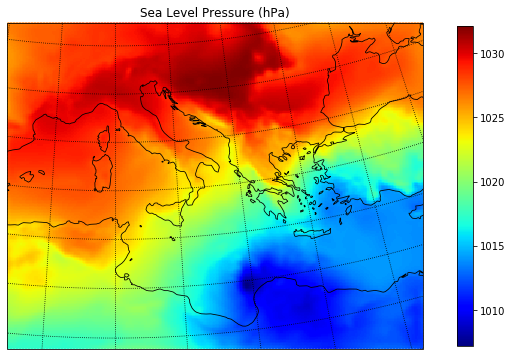

In [5]:
# Create a figure
fig = plt.figure(figsize=(12,6))
# Set the GeoAxes to the projection used by WRF
ax = plt.axes(projection=cart_proj)

# Download and add the states and coastlines
states = NaturalEarthFeature(category="cultural", scale="50m",
                             facecolor="none",
                             name="admin_1_states_provinces_shp")
ax.add_feature(states, linewidth=0.8, edgecolor="black")
ax.coastlines('50m', linewidth=0.8)

plt.pcolormesh(to_np(lons), to_np(lats), to_np(smooth_slp),
             transform=crs.PlateCarree(),
             cmap=get_cmap("jet"))

# Add a color bar
plt.colorbar(ax=ax, shrink=.98)

# Set the map bounds
ax.set_xlim(cartopy_xlim(smooth_slp))
ax.set_ylim(cartopy_ylim(smooth_slp))

# Add the gridlines
ax.gridlines(color="black", linestyle="dotted")

plt.title("Sea Level Pressure (hPa)")

plt.show()

### Moving to plot a vertical level (500 hPa)

Loading variables using wrf-python getvar (you can specify units - here we use dm for height and knots for wind)

In [6]:
# Extract the pressure, geopotential height, and wind variables
p = getvar(ncfile, "pressure")
z = getvar(ncfile, "z", units="dm")
ua = getvar(ncfile, "ua", units="kt")
va = getvar(ncfile, "va", units="kt")
wspd = getvar(ncfile, "wspd_wdir", units="kts")[0,:]

Interpolation to pressure level 500 hPa

In [7]:
# Interpolate geopotential height, u, and v winds to 500 hPa
ht_500 = interplevel(z, p, 500)
u_500 = interplevel(ua, p, 500)
v_500 = interplevel(va, p, 500)
wspd_500 = interplevel(wspd, p, 500)

Getting geographical information

In [8]:
# Get the lat/lon coordinates
lats, lons = latlon_coords(ht_500)

# Get the map projection information
cart_proj = get_cartopy(ht_500)

Plotting geopotential heihgt at 500hPa (contours), wind speed (shaded contours) and wind barbs

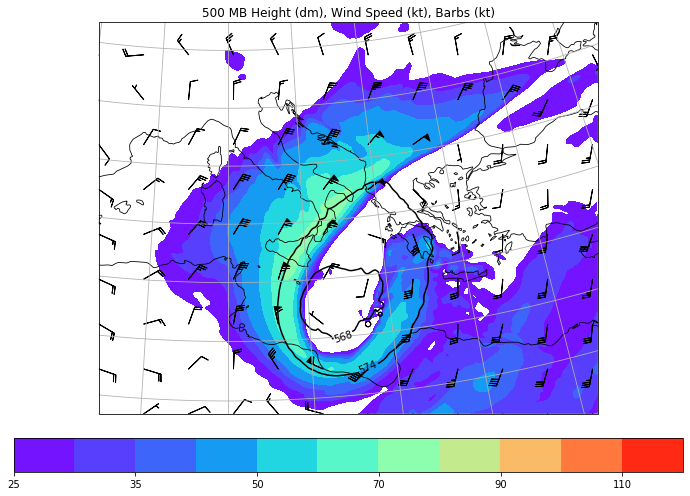

In [10]:
# Create the figure
fig = plt.figure(figsize=(12,9))
ax = plt.axes(projection=cart_proj)

# Download and add the states and coastlines
states = NaturalEarthFeature(category="cultural", scale="50m",
                             facecolor="none",
                             name="admin_1_states_provinces_shp")
ax.add_feature(states, linewidth=0.5, edgecolor="black")
ax.coastlines('50m', linewidth=0.8)

# Add the 500 hPa geopotential height contours
levels = np.arange(520., 580., 6.)
contours = plt.contour(to_np(lons), to_np(lats), to_np(ht_500),
                       levels=levels, colors="black",
                       transform=crs.PlateCarree())
plt.clabel(contours, inline=1, fontsize=10, fmt="%i")

# Add the wind speed contours
levels = [25, 30, 35, 40, 50, 60, 70, 80, 90, 100, 110, 120]
wspd_contours = plt.contourf(to_np(lons), to_np(lats), to_np(wspd_500),
                             levels=levels,
                             cmap=get_cmap("rainbow"),
                             transform=crs.PlateCarree())
plt.colorbar(wspd_contours, ax=ax, orientation="horizontal", pad=.05)

# Add the 500 hPa wind barbs, only plotting every 125th data point.
plt.barbs(to_np(lons[::25,::25]), to_np(lats[::25,::25]),
          to_np(u_500[::25, ::25]), to_np(v_500[::25, ::25]),
          transform=crs.PlateCarree(), length=6)

# Set the map bounds
ax.set_xlim(cartopy_xlim(ht_500))
ax.set_ylim(cartopy_ylim(ht_500))

ax.gridlines()

plt.title("500 MB Height (dm), Wind Speed (kt), Barbs (kt)")

plt.show()